<a href="https://colab.research.google.com/github/sganguly3000ai/makemore/blob/main/makemore_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bigram character level language model using neural network MLP Wavenet**

In [ ]:
import torch
import numpy as np
import string
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd
%matplotlib inline


In [ ]:
# the yob1996.txt file is locally stored in the downloads/names directory
# and should be uploaded to the sample_data directory in colab before running
# create a list of words or names

# create a list of words or names

names   = np.loadtxt('sample_data/yob1996.txt', delimiter=',', usecols = 0, dtype = str)
lnames  = np.char.lower(names)
words  = pd.unique(lnames)



In [ ]:
print(f'{names[:8]} :Shape = {names.shape}\n{lnames[:8]} :Shape = {lnames.shape}\n{words[:8]} :Shape = {words.shape}')


['Emily' 'Jessica' 'Ashley' 'Sarah' 'Samantha' 'Taylor' 'Hannah' 'Alexis'] :Shape = (26426,)
['emily' 'jessica' 'ashley' 'sarah' 'samantha' 'taylor' 'hannah' 'alexis'] :Shape = (26426,)
['emily' 'jessica' 'ashley' 'sarah' 'samantha' 'taylor' 'hannah' 'alexis'] :Shape = (24306,)


In [ ]:
# create a dictionary of the lowercase english alphabets + '.' as the start and end character for a word

chars = list(string.ascii_lowercase)
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size=len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
def build_dataset(words):
  X, Y = [],[]


  for w in words:
    context = [0] * block_size

    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '---->', itos[ix])
      context = context[1:] + [ix] #crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape,Y.shape)
  return X, Y

np.random.seed(42)
np.random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

# train,dev and test datasets (80,10,10)
Xtr, Ytr        =  build_dataset(words[:n1])
Xdev, Ydev      =  build_dataset(words[n1:n2])
Xtest, Ytest    =  build_dataset(words[n2:])


torch.Size([142863, 3]) torch.Size([142863])
torch.Size([17771, 3]) torch.Size([17771])
torch.Size([17942, 3]) torch.Size([17942])


In [ ]:
# lets train a deeper network

class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight   = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias     = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps        = eps
    self.momentum   = momentum
    self.training   = True
    # parameters trained with backprop
    self.gamma      = torch.ones(dim)
    self.beta       = torch.zeros(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean         = x.mean(0, keepdim=True)                   # batch mean
      xvar          = x.var(0, keepdim=True, unbiased=True)     # batch variance
    else:
      xmean         = self.running_mean
      xvar          = self.running_var
    xhat            = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out        = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean   = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var    = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out       = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd       = 10                                         # the dimensionality of the character embedding vectors
n_hidden    = 100                                         # the number of neurons in the hidden layer of the MLP
g           = torch.Generator().manual_seed(2147483647)   # for reproducibility

C           =   torch.randn((vocab_size,n_embd),             generator = g)
layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
  # last layer make less confident
  layers[-1].weight *= 0.1
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))               # number of parameters in total
for p in parameters:
  p.requires_grad = True

print(len(layers))


46497
11


In [ ]:
# same optimization as last time

max_steps       = 200000
batch_size      = 32
lossi           = []

for i in range(max_steps):

  # minibatch construct (pluck bath_size samples out of the total number of samples randomly
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]


  # forward pass
  emb       = C[Xb]                       # embed the characters into vectors
  x         = emb.view(emb.shape[0], -1)  # concatenate the vectors
  # linear layer
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb)      # loss function

  # backward pass
  '''
  for layer in layers:
    layer.out.retain_grad()       # AFTER-DEBUG:  would take out retain_grad()
  '''
  for p in parameters:
    p.grad = None
  loss.backward()

  # gradient update
  lr = 0.1 if i < 100000 else .01         # step learning rate decay
  for p in parameters:
    #lr        = lrs[i]
    p.data   += -lr * p.grad

  # track stats
  if i % 10000 == 0:                      # print every 10000 iterations
    print(f'{i:7d}/{max_steps:7d}: {loss.item():4f}')
  lossi.append(loss.log10().item())

  #break # AFTER_DEBUG: would take out obviously to runn full optimization

      0/ 200000: 2.122845
  10000/ 200000: 1.559028
  20000/ 200000: 1.223083
  30000/ 200000: 1.826880
  40000/ 200000: 2.338053
  50000/ 200000: 2.094831
  60000/ 200000: 2.087000
  70000/ 200000: 1.737206
  80000/ 200000: 1.886649
  90000/ 200000: 2.029052
 100000/ 200000: 1.756813
 110000/ 200000: 1.695763
 120000/ 200000: 1.865881
 130000/ 200000: 1.663840
 140000/ 200000: 1.751780
 150000/ 200000: 2.007887
 160000/ 200000: 2.144787
 170000/ 200000: 1.862404
 180000/ 200000: 1.932222
 190000/ 200000: 1.762457


In [ ]:
# run to evaluate what the train and validation data is showing as per as the loss

@torch.no_grad()                                # this decorator disables gradient tracking
def split_loss(split):
  x,y = {'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xtest, Ytest),
        }[split]

  # forward pass
  emb       = C[x]                          # embed the characters into vectors
  xsp         = emb.view(emb.shape[0], -1)  # concatenate the vectors
  for layer in layers:
    xsp = layer(xsp)
  loss = F.cross_entropy(xsp, y)      # loss function

  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.8816947937011719
val 2.046818971633911


In [ ]:
# sample from the model

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

  out = []
  context = [0]*block_size # initialize with all '...'
  while True:

    emb     = C[torch.tensor([context])]
    xsamp         = emb.view(emb.shape[0], -1)
    for layer in layers:
      xsamp = layer(xsamp)

    probs   = F.softmax(xsamp, dim=1)

    # sample from the distribution
    ix      = torch.multinomial(probs, num_samples=1, generator=g).item()
    # shift the context window and track the samples
    context = context[1:] + [ix]

    out.append(ix)
    # if we sample the special '.' token, break
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))


montaymandrice.
mad.
ryana.
emmanterrine.
cadejaniel.
themi.
jenne.
elissa.
naraely.
kohltarin.
shabrigihiraeshan.
josell.
panterian.
brence.
ruy.
juliek.
yule.
mistonesshalina.
yanny.
juan.


In [ ]:
# MLP revisited
n_emb       = 10 # the dimensionality of the character embedding vectors
n_hidden    = 200 # the number of neurons in the hidden layer of the MLP

# define the parameters
g   =   torch.Generator().manual_seed(2147483647)         # for reproducibility
C   =   torch.randn((vocab_size,n_emb),             generator = g)
W1  =   torch.randn((n_emb*block_size, n_hidden),   generator = g) * (5/3)/((n_emb * block_size) ** 0.5) # # look at torch.nn.init.kaiming_normal_
# b1  =   torch.randn((n_hidden),                     generator = g) * 0.01
W2  =   torch.randn((n_hidden,vocab_size),          generator = g) * 0.01
b2  =   torch.randn((vocab_size),                   generator = g) * 0  # trying to get the logits close to 0 at initialization

# batch normalization gains and biases
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters  = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))                              # number of parameters in total

for p in parameters:
  p.requires_grad = True

12297


In [ ]:
# to figure out what learning rate to use
# guess a learning rate (one low and one high)
# plug in the (guessed) low learning rate and train the model - observe the rate at which the loss is going down
# plug in the (guessed) high learning rate and train the model - observe the rate at which the loss is going down
# the (guessed) low and high lr should both not make the loss go down fairly quickly
# for this particular model it seems like the low and high should be .001 and 1

lre = torch.linspace(-3,0,1000)   # create evenly spaced values between -3 and 0
lrs = 10**lre                     # taking the exponent gives us a tensor of values in the range 1 and .001

# now instead of using the guessed learning rate (lr), we will run the model with each learning rate in lrs
# and track the losses for a 1000 iterations of training the model

In [ ]:
hpreact.shape

torch.Size([32, 200])

In [ ]:
hpreact.mean(0, keepdim = True).shape

torch.Size([1, 200])

In [ ]:
hpreact.std(0, keepdim = True).shape

torch.Size([1, 200])

In [ ]:
# same optimization as last time

max_steps       = 200000
batch_size      = 32
lossi           = []

for i in range(max_steps):

  # minibatch construct (pluck bath_size samples out of the total number of samples randomly
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]


  # forward pass
  emb       = C[Xb]                       # embed the characters into vectors
  x         = emb.view(emb.shape[0], -1)  # concatenate the vectors
  # linear layer
  for layer in layers:
    x = layer[x]
  loss = F.cross_entropy(logits, Yb)      # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad()       # AFTER-DEBUG:  would take out retain_grad()
  for p in parameters:
    p.grad = None
  loss.backward()

  # BatchNorm layer
  # ------------------------------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim = True)
  bnstdi  = hpreact.std(0, keepdim = True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias  # batch normalization

  # the mean and std running are not trained by the gradient they are simply update with arithmatic operations
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  # ------------------------------------------------------------------------------------
  # Non-linearity
  h         = torch.tanh(hpreact)         # hidden layer
  logits  = h @ W2 + b2                   # output layer
  # counts  = logits.exp()
  # probs   = counts / counts.sum(1, keepdims = True)
  # loss    = -probs[torch.arange(num_of_labels),Y].log().mean()
  loss = F.cross_entropy(logits, Yb)      # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad()       # AFTER-DEBUG:  would take out retain_grad()
  for p in parameters:
    p.grad = None
  loss.backward()

  # gradient update
  lr = 0.1 if i < 100000 else .01         # step learning rate decay
  for p in parameters:
    #lr        = lrs[i]
    p.data   += -lr * p.grad

  # track stats for lr
  if i % 10000 == 0:                      # print every 10000 iterations
    print(f'{i:7d}/{max_steps:7d}: {loss.item():4f}')
  lossi.append(loss.item())



      0/ 200000: 3.306904
  10000/ 200000: 1.972377
  20000/ 200000: 2.623867
  30000/ 200000: 2.252633
  40000/ 200000: 2.153543
  50000/ 200000: 2.601152
  60000/ 200000: 2.163505
  70000/ 200000: 2.233273
  80000/ 200000: 2.069710
  90000/ 200000: 2.130016
 100000/ 200000: 2.244243
 110000/ 200000: 1.930052
 120000/ 200000: 2.016576
 130000/ 200000: 1.689035
 140000/ 200000: 2.033951
 150000/ 200000: 1.962354
 160000/ 200000: 1.611683
 170000/ 200000: 2.146210
 180000/ 200000: 2.069461
 190000/ 200000: 2.161836


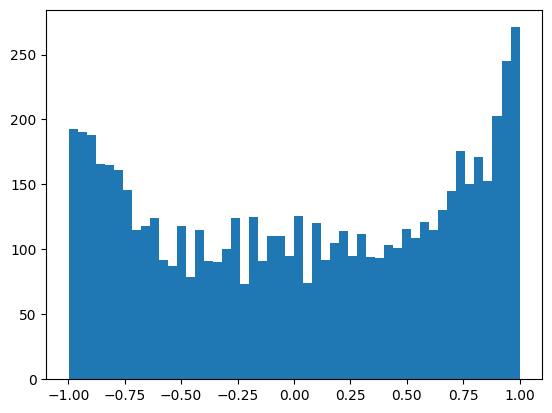

In [ ]:
plt.hist(h.view(-1).tolist(), 50); # by doing this we can observe that the values in h are mostly close to 1 ot -1

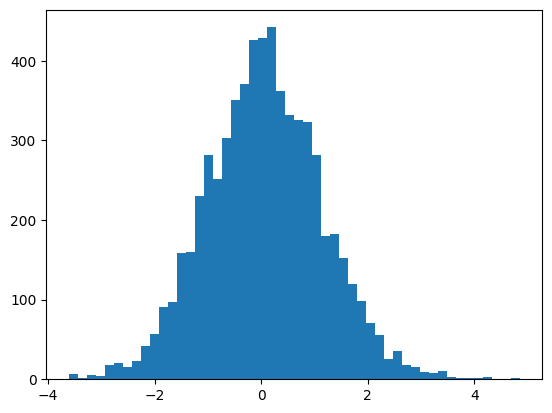

In [ ]:
plt.hist(hpreact.view(-1).tolist(), 50);  # by doing this we can observe that the pre-activation values are pretty broad (-15 - 15)

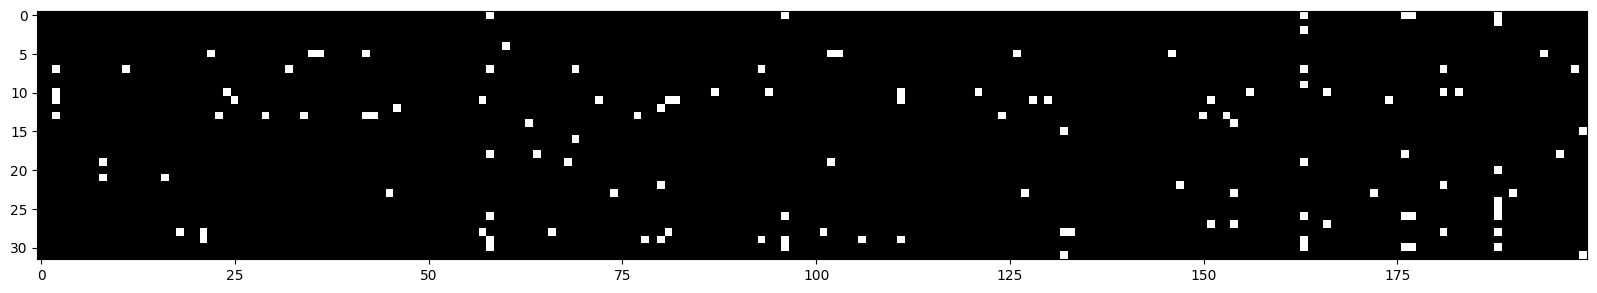

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
# tyring to visualize how many values in h are greater than .99.
# white if true, black if false (h.abs() > 0.99)
# if we have an entire column that is white that will indicate a DEAD neuron - that is the neuron has no effect on the gradient and the neuron
# will never learn

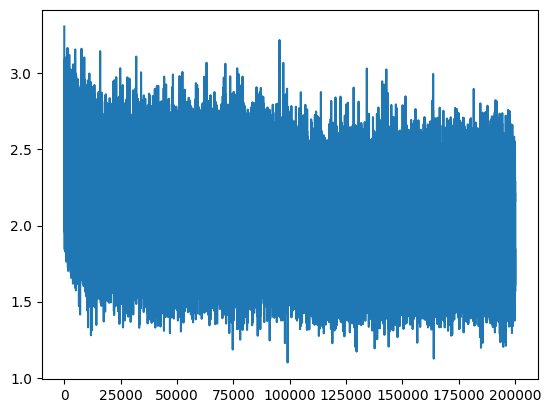

In [ ]:
plt.plot(lossi)

In [ ]:
# calibrate the batch norm statistics at the end of training
# just to check that the bnmean and bnstd are very close to bnmean_running and bnstd_running

with torch.no_grad():
  # pass the training set through
  emb       = C[Xtr]                       # embed the characters into vectors
  embcat    = emb.view(emb.shape[0], -1)  # concatenate the vectors
  hpreact   = embcat @ W1 # + b1            # hidden layer pre-activation
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim = True)
  bnstd  = hpreact.std(0, keepdim = True)

In [ ]:
bnmean

tensor([[-1.5223e+00, -9.6379e-02, -1.1707e+00, -1.1808e-01, -1.6449e-01,
         -2.3191e-03,  1.6186e+00, -4.4676e-01,  1.0015e+00,  1.0830e+00,
         -2.9481e+00, -1.4626e+00,  5.4658e-01,  3.2607e-01,  2.1515e-01,
          4.2718e-01, -3.8980e-01, -3.1701e+00, -7.4951e-01,  1.0053e+00,
          8.9451e-01, -1.4186e+00, -6.1334e-02,  8.1873e-01,  5.1248e-01,
          6.4680e-01, -4.7563e-01, -7.3507e-04,  2.1894e-02,  7.0873e-01,
         -9.2831e-01, -7.6017e-01, -1.2802e-01,  6.4737e-01,  3.2138e-01,
         -1.3637e+00,  8.1971e-01,  4.0963e-01, -3.8844e-01, -4.7502e-01,
          4.6924e-01, -6.5025e-01, -9.7760e-03,  1.1191e-01,  1.1573e+00,
         -7.6343e-01,  1.4582e+00, -2.2325e-01,  2.3803e+00,  1.3296e+00,
          4.8551e-01,  7.1141e-01,  1.2089e+00,  5.7592e-01,  1.6376e+00,
         -9.8056e-01,  4.7065e-01,  1.9584e-01,  7.8827e-01, -6.0425e-01,
         -4.0996e-01,  1.2874e+00, -8.4235e-02, -4.0257e-01,  6.7699e-01,
          1.1614e+00,  1.0924e+00,  1.

In [ ]:
bnmean_running

tensor([[-1.5099, -0.0850, -1.1796, -0.1336, -0.1537,  0.0111,  1.6051, -0.4541,
          1.0064,  1.0749, -2.9482, -1.4594,  0.5602,  0.3279,  0.2309,  0.4472,
         -0.3694, -3.1711, -0.7364,  1.0050,  0.8996, -1.4184, -0.0739,  0.8228,
          0.5032,  0.6401, -0.4626,  0.0243,  0.0285,  0.7158, -0.9239, -0.7644,
         -0.1190,  0.6513,  0.3299, -1.3636,  0.8299,  0.4157, -0.3734, -0.4731,
          0.4718, -0.6576, -0.0202,  0.1204,  1.1647, -0.7666,  1.4616, -0.2124,
          2.3966,  1.3245,  0.4925,  0.7136,  1.1827,  0.5698,  1.6322, -0.9738,
          0.4877,  0.1806,  0.8038, -0.6094, -0.4167,  1.2890, -0.0932, -0.4019,
          0.6778,  1.1806,  1.0955,  1.0971, -1.4633, -0.4456,  0.0590,  0.0428,
          1.2194, -2.2546, -2.3172, -0.2861,  1.2898, -0.4525, -0.4012,  0.7476,
          0.2695,  0.3898,  1.3797,  0.3578, -1.0840, -0.8631, -1.6620, -0.5437,
         -0.1989,  0.1005, -0.5396, -0.1443, -0.8439,  0.0493, -1.8330,  0.5239,
         -1.5048, -0.9536, -

In [ ]:
# run to evaluate what the train and validation data is showing as per as the loss

@torch.no_grad()                                # this decorator disables gradient tracking
def split_loss(split):
  x,y = {'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xtest, Ytest),
        }[split]

  emb       = C[x]                       # embed the characters into vectors
  embcat    = emb.view(emb.shape[0], -1)  # concatenate the vectors
  hpreact   = embcat @ W1 # + b1            # hidden layer pre-activation
  # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim = True)) / hpreact.std(0, keepdim = True) + bnbias  # batch normalization
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h         = torch.tanh(hpreact)         # hidden layer
  logits  = h @ W2 + b2
  loss = F.cross_entropy(logits, y)       # loss function
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9901783466339111
val 2.056513547897339


2.5666401386260986


2.5784599781036377


In [ ]:
# sample from the model

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

  out = []
  context = [0]*block_size # initialize with all '...'
  while True:

    emb     = C[torch.tensor([context])]                                          #(1,block_size,d)
    h       = torch.tanh(emb.view(1,-1) @ W1 + b1)
    logits  = h @ W2 + b2
    probs   = F.softmax(logits, dim=1)

    # sample from the distribution
    ix      = torch.multinomial(probs, num_samples=1, generator=g).item()
    # shift the context window and track the samples
    context = context[1:] + [ix]

    out.append(ix)
    # if we sample the special '.' token, break
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))

montaymyazharel.
ndinyah.
tedvastendra.
gradejadielin.
shy.
jenne.
elisson.
arleilyn.
shara.
nyshabergiagriel.
kinde.
jenne.
nicolfou.
marcel.
kylene.
eli.
kayshaquelle.
halisa.
yanny.
aubrelle.


In [ ]:
# our models initialization is not correct, since it starts with a very high loss and drops down quickly

# 4-dimensional example of the isse

logits  = torch.tensor([0.0, 5.0, 0.0, 0.0])
probs   = torch.softmax(logits, dim=0)
loss    = -probs[2].log()
probs,loss
# if logits[2] BY CHANCE at initialization got a high number the loss will be very low
# if some other element of logits has a higher number than [2] then the loss will be higher
# the trick is to have the logits at initialization to be close to 0

(tensor([0.0066, 0.9802, 0.0066, 0.0066]), tensor(5.0200))

tensor(0.0155) tensor(1.0018)
tensor(-0.0021) tensor(0.9930)


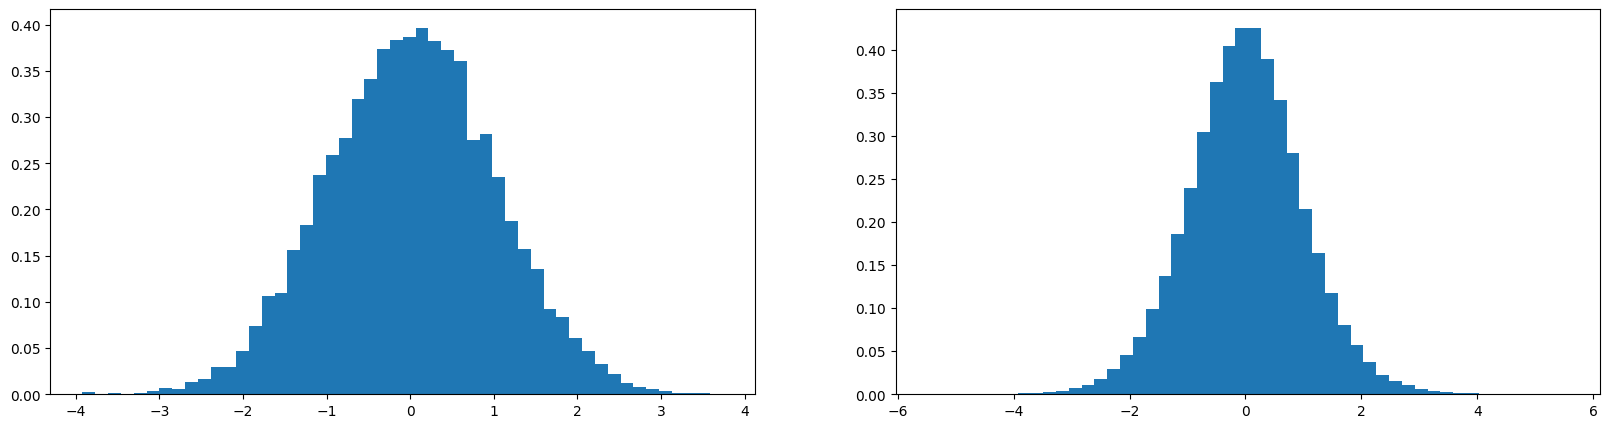

In [ ]:
# look at torch.nn.init.kaiming_normal_
x = torch.randn(1000,10)
w = torch.randn(10,200) / 10**0.5                        # square root of fan in or input (10)
y = x @ w
print (x.mean(), x.std())
print (y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density = True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density = True);